In [1]:
import numpy as np
import math
import scipy
from scipy import linalg
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter, MultipleLocator
from mod2 import mod10_to_mod2 as dec2bin

Create function for an n-qubit statevector emulator.

In [2]:
def ket2state_vec(ket):
    
    #basis states
    zero=np.array([1,0])
    one=np.array([0,1]) 
    
    #loop through ket
    
    if ket[0]==0: temp=zero
    elif ket[0]==1: temp=one
    
    for i,_ in enumerate(ket):
        
        if i == len(ket)-1: break
            
        if ket[i+1]==0: temp2=zero
        elif ket[i+1]==1: temp2=one
    
        temp=np.kron(temp,temp2)
        
    return temp

Define the Pauli Matrices, the identity & a general kron (tensor product) function.

In [3]:
# Pauli matrices
p_x = np.array([[0.,  1.], [1.,  0.]])
p_y = np.array([[0., -1j], [1j,  0.]])
p_z = np.array([[1.,  0.], [0., -1.]])
I = np.identity(2)

def k_kron(*args):
    """
    The standard Python kron function takes only 2 inputs at a time by default, so we define another function that 
    takes in arbitrary inputs.
    """
    ret = np.array([[1]])
    for q in args:
        ret = np.kron(ret, q)
    return ret

Create a function for state transfer over spin chain of length n, based on Hamiltonian for the Heisenberg XY model. 

In [4]:
def exchangeH(n):
    
    def J(k,n):
        return (1/2)*math.sqrt((k+1)*(n-(k+1)))
    
    h=np.zeros((2**n,2**n)).astype("complex128")

    for k in range(n-1):
        kron_list=[I]*n       
        kron_list[k]=p_x 
        kron_list[k+1]=p_x 

        h+=J(k,n)*k_kron(*kron_list)

    for k in range(n-1):
        kron_list=[I]*n       
        kron_list[k]=p_y
        kron_list[k+1]=p_y

        h+=J(k,n)*k_kron(*kron_list)   
        
    return(h/2)

Define functions for unitary time evolution, computing fidelity of state transfer and generating arbitrary states.

In [5]:
def timeev(h,t):
    return linalg.expm(-1j*h*t)
def U(t):
    return timeev(h,t)

def fidelity(S,evS):
    fidelity= abs(np.conjugate(S.T)@evS)
    return fidelity

def normalise(vec): 
    norm=np.sqrt(np.conjugate(vec).T@vec)
    return vec/norm
#function for creating  superposition states
def superposition_state(a,b):
  psi=a*ket2state_vec([0])+b*ket2state_vec([1])
  return normalise(psi)

Example initial and target states for state transfer.

In [6]:
psi=ket2state_vec([1]) # |1>

n=3 #spin chain length
temp = ket2state_vec([0]*(n-1)) # |000...>

#intial spin chain state (psi on left)
def initial(psi):
    return np.kron(psi,temp) # initial= |psi>\otimes |000...>

#final spin chain state (psi on right)
def target(psi):
    return np.kron(temp,psi) # target= |000...> \otimes |psi>

initial(psi), target(psi)

(array([0, 0, 0, 0, 1, 0, 0, 0]), array([0, 1, 0, 0, 0, 0, 0, 0]))

Plot Fidelity over time for state transfer over spin chain of length n.

Text(0.5, 1.0, 'State Transfer for state |1>  (XY, n=3 spin chain).')

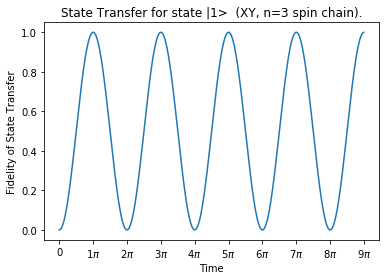

In [7]:
h=exchangeH(n)

psi0= initial(psi)
psi1= target(psi)

timeS=(math.pi)*np.arange(0,9,0.01)

f_list=[]

for t in timeS:

    evS=U(t)@psi0
    f=fidelity(psi1,evS)
    f_list.append(f)
    
f, ax=plt.subplots(1)
    
plt.plot(timeS, f_list)
ax.xaxis.set_major_formatter(FuncFormatter(
   lambda val,pos: '{:.0g}$\pi$'.format(val/np.pi) if val !=0 else '0'
))
ax.xaxis.set_major_locator(MultipleLocator(base=np.pi))
plt.xlabel("Time")
plt.ylabel("Fidelity of State Transfer")
plt.title('State Transfer for state |1>  (XY, n=3 spin chain).')

Example initial and target states for state transfer of equal superposition state.

In [8]:
psi=superposition_state(a=1,b=1) #equal superposition state

initial(psi), target(psi)

(array([0.70710678, 0.        , 0.        , 0.        , 0.70710678,
        0.        , 0.        , 0.        ]),
 array([0.70710678, 0.70710678, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ]))

Plot Fidelity over time for state transfer of equal superposition over spin chain of length n.

Text(0.5, 1.0, 'State Transfer for equal superposition (XY, n=3 spin chain).')

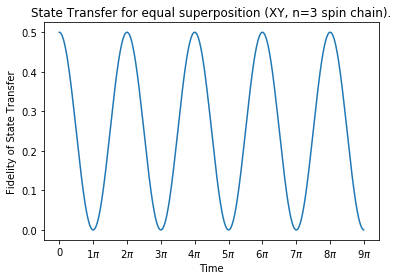

In [9]:
psi0= initial(psi)
psi1= target(psi)

timeS=(math.pi)*np.arange(0,9,0.01)

f_list=[]

for t in timeS:

    evS=U(t)@psi0
    f=fidelity(psi1,evS)
    f_list.append(f)
    
f, ax=plt.subplots(1)
    
plt.plot(timeS, f_list)
ax.xaxis.set_major_formatter(FuncFormatter(
   lambda val,pos: '{:.0g}$\pi$'.format(val/np.pi) if val !=0 else '0'
))
ax.xaxis.set_major_locator(MultipleLocator(base=np.pi))
plt.xlabel("Time")
plt.ylabel("Fidelity of State Transfer")
plt.title('State Transfer for equal superposition (XY, n=3 spin chain).')

For superposition states, the transfer is accurate only upto a systematic phase $\phi$, so we need to apply a phase correction to restore perfect state transfer for spin chains of odd length, and create a function to generate these corrections.

In [10]:
def phC(n):
    
    def J(k,n):
        return (1/2)*math.sqrt((k+1)*(n-(k+1)))
    
    phC=[]
    
    for i in range(2**n):
        binary_number=dec2bin(i,n)  
        w_x=np.sum(binary_number) 
        pC_t=scipy.special.binom(w_x, 2)
        for k in range(n):
            theta=((2*k)-1)*(math.pi*(n-1))/2
        from math import e
        pC= e**(-1j*theta*w_x)*(-1)**(pC_t)

        phC.append(pC)
    
    return(phC)

Plot for state transfer of equal superposition over spin chain of length n with phase corrections.

Text(0.5, 1.0, 'State Transfer for equal superposition (XY, n=3 spin chain, phase corrected).')

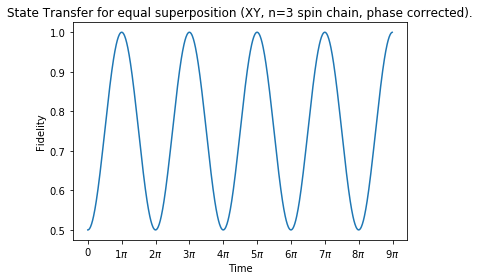

In [11]:
timeS=(math.pi)*np.arange(0,9,0.01)

f_list=[]
lst=phC(n)

for t in timeS:
    evS=U(t)@psi0 #evolved state
    st=evS

    for j,_ in enumerate(st):
        st[j]=lst[j]*st[j]

    f=fidelity(psi1,evS) #evolved state*correction
    f_list.append(f)
    
f, ax=plt.subplots(1)
    
plt.plot(timeS, f_list)
ax.xaxis.set_major_formatter(FuncFormatter(
    lambda val,pos: '{:.0g}$\pi$'.format(val/np.pi) if val !=0 else '0'
))
ax.xaxis.set_major_locator(MultipleLocator(base=np.pi))
plt.xlabel("Time")
plt.ylabel("Fidelity")
plt.title('State Transfer for equal superposition (XY, n=3 spin chain, phase corrected).')

Now try state transfer for a random superposition, and generate corresponding plot with phase corrections. 

Text(0.5, 1.0, 'State Transfer for random superposition (XY, n=3 spin chain, phase corrected).')

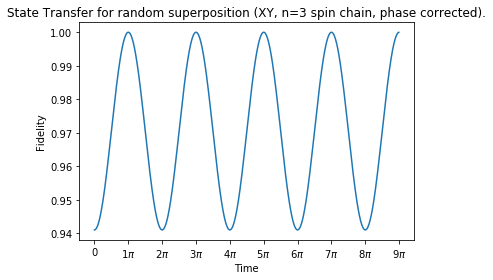

In [12]:
#random state
a=np.random.random()+1j*np.random.random() 
b=np.random.random()+1j*np.random.random()
psi=superposition_state(a,b)

psi0= initial(psi)
psi1= target(psi)

timeS=(math.pi)*np.arange(0,9,0.01)

f_list=[]
lst=phC(n)

for t in timeS:
 
    evS=U(t)@psi0 #evolved state
    st=evS

    for j,_ in enumerate(st):
        st[j]=lst[j]*st[j]

    f=fidelity(psi1,evS) 
    f_list.append(f)
    
f, ax=plt.subplots(1)
    
plt.plot(timeS, f_list)
ax.xaxis.set_major_formatter(FuncFormatter(
    lambda val,pos: '{:.0g}$\pi$'.format(val/np.pi) if val !=0 else '0'
))
ax.xaxis.set_major_locator(MultipleLocator(base=np.pi))
plt.xlabel("Time")
plt.ylabel("Fidelity")
plt.title('State Transfer for random superposition (XY, n=3 spin chain, phase corrected).')